# 🧠 Facial Symmetry Analysis with MediaPipe

This project aims to analyze facial symmetry using computer vision and facial landmark detection. Facial symmetry is often associated with aesthetics, health, and even emotional expression. By automatically detecting facial landmarks and computing geometric measurements, we can objectively quantify how symmetrical a face is.

## 📌 What This Project Does:
- Uses **MediaPipe Face Mesh** to detect 468 facial landmarks from a static image.
- Draws a **facial midline** based on central landmarks (nose, chin, forehead).
- Separates and visualizes the left and right sides of the face.
- Computes a **Facial Asymmetry Score** by comparing mirrored landmark positions.
- Highlights which side of the face contributes more to asymmetry.
- Visualizes points with the highest deviations for deeper insight.


> 💡 Note: Slight asymmetry is completely normal and common in all human faces.


In [54]:
#import libraries

import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt



## 📌 Facial Landmark Detection and Midline Estimation

This cell performs facial analysis using **MediaPipe’s Face Mesh**, which detects **468 facial landmarks** from a static image.

### What this code does:
- Loads and converts the input image to the correct color format.
- Uses **MediaPipe FaceMesh** to detect a face and its landmarks.
- Draws each detected landmark as a small **green dot**.
- Defines a facial **midline** using 6 key landmarks along the **nose bridge**:  
  Landmarks: `1, 2, 98, 327, 168, 152`.
- Calculates the average X-coordinate of these points to estimate the **midline of the face**.
- Draws the midline as a **vertical red line** from top to bottom.

### Why this matters:
The midline acts as a central reference to measure **facial symmetry**, which will be analyzed in the following steps.


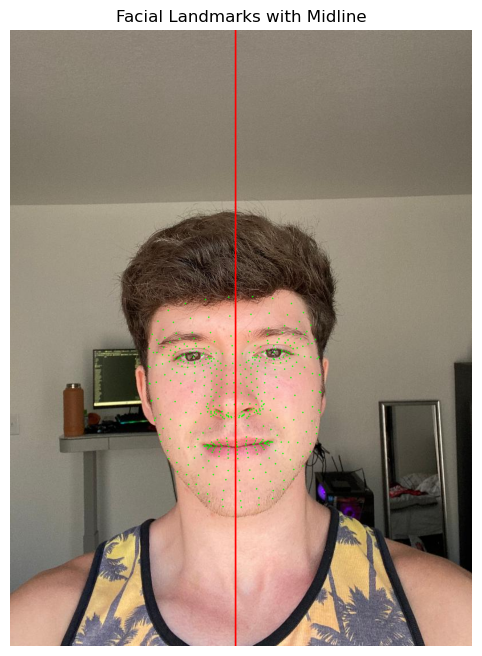

In [55]:

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

# Load image
image_path = "newface.jpg"
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Detect face landmarks
results = face_mesh.process(image_rgb)

if results.multi_face_landmarks:
    annotated_image = image_rgb.copy()
    h, w, _ = image_rgb.shape
    
    # Draw landmarks
    for face_landmarks in results.multi_face_landmarks:
        for lm in face_landmarks.landmark:
            x, y = int(lm.x * w), int(lm.y * h)
            cv2.circle(annotated_image, (x, y), 1, (0, 255, 0), -1)

            # Use multiple landmarks along the nose bridge to define midline
            midline_indices = [1, 2, 98, 327, 168, 152]
            
            # Extract x-coordinates of these landmarks
            x_coords = [int(face_landmarks.landmark[i].x * w) for i in midline_indices]
            
            # Average the x values to get a robust midline x
            mid_x = int(sum(x_coords) / len(x_coords))
            
            # Draw midline (vertical red line)
            cv2.line(annotated_image, (mid_x, 0), (mid_x, h), (255, 0, 0), 2)
            
    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image)
    plt.title("Facial Landmarks with Midline")
    plt.axis('off')
    plt.show()
else:
    print("No face detected.")



## 🔍 Visualizing Left and Right Facial Landmarks

This cell focuses on **separating and visualizing the left and right sides** of the face based on the estimated **facial midline**.

### 🧠 What this code does:
- Converts the full set of 468 landmarks into pixel coordinates.
- Estimates the **facial midline** using three key landmarks:
  - `1`: Glabella (between eyebrows)
  - `10`: Nose tip
  - `152`: Chin
- Averages their X-coordinates to determine the vertical **midline**.
- Splits all landmarks into:
  - **Left side**: Landmarks to the left of the midline
  - **Right side**: Landmarks to the right of the midline
- Draws the **midline** on the original image (red vertical line).
- Plots each side’s landmarks separately:
  - **Red dots** = Right side of the actual face (camera-left)
  - **Blue dots** = Left side of the actual face (camera-right)

### 🧭 Why this is useful:
By clearly separating the sides of your face, this visualization helps identify any **visible asymmetry** and supports further analysis in upcoming cells.


Facial midline estimated at x = 394


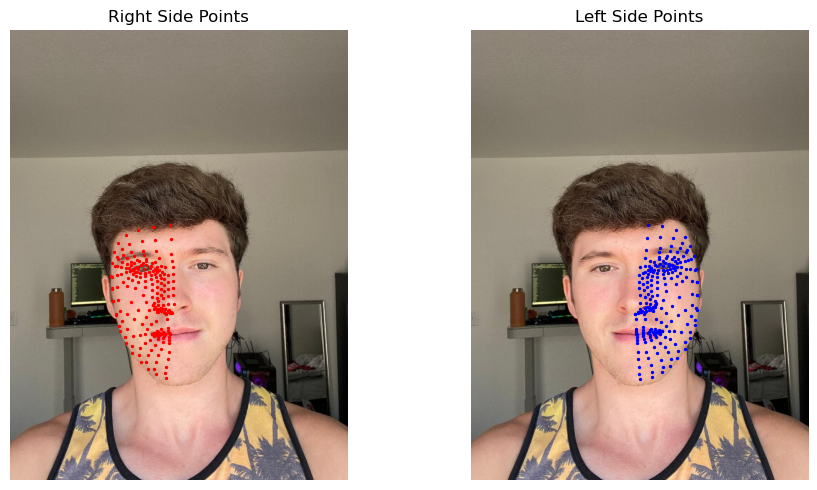

In [57]:
# Extract landmark points (x, y)
h, w, _ = image_rgb.shape
landmark_points = []

for lm in face_landmarks.landmark:
    x = int(lm.x * w)
    y = int(lm.y * h)
    landmark_points.append((x, y))

# Use facial landmarks to define midline (nose tip, chin, glabella)
midline_indices = [1, 10, 152]
midline_xs = []

for idx in midline_indices:
    lm = face_landmarks.landmark[idx]
    x = int(lm.x * w)
    midline_xs.append(x)

# Calculate average X of midline landmarks
mid_x = int(np.mean(midline_xs))
print(f"Facial midline estimated at x = {mid_x}")

# Draw midline in red with thickness 2
cv2.line(image_bgr, (mid_x, 0), (mid_x, image_bgr.shape[0]), (0, 0, 255), 2)

# Split into left and right points
left_side_points = [pt for pt in landmark_points if pt[0] < mid_x]
right_side_points = [pt for pt in landmark_points if pt[0] > mid_x]

# Visualize left and right landmarks
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Right Side Points")  # <- camera-facing right = real left
for pt in left_side_points:
    plt.scatter(pt[0], pt[1], c='red', s=2)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rgb)
plt.title("Left Side Points")  # <- camera-facing left = real right
for pt in right_side_points:
    plt.scatter(pt[0], pt[1], c='blue', s=2)
plt.axis('off')

plt.tight_layout()
plt.show()


## 📏 Step 5: Compute Facial Asymmetry Score

This section defines and uses a function to **quantify facial asymmetry** using landmark distances.

### 🧠 What this code does:
- **Mirrors** the landmarks from the right side of the face across the estimated **facial midline**.
- **Pairs** each mirrored right-side landmark with its corresponding left-side landmark.
- Computes the **Euclidean distance** between each left-side point and its mirrored counterpart.
- Averages these distances to produce a **Facial Asymmetry Score**.

### 📊 What the score means:
- The final number is measured in **pixels** and represents the **average deviation** between mirrored landmarks.
- A **lower score** indicates a more **symmetrical face**, while a **higher score** suggests greater asymmetry.

> For example:  
> `My Facial Asymmetry Score: 111.78 pixels`  
> means that on average, mirrored features deviate from symmetry by ~112 pixels in my image.

#### 🔢 Expected Range (Approximate):

| Asymmetry Score (px) | Interpretation                                                  |
|----------------------|------------------------------------------------------------------|
| **0–30 px**           | Very symmetrical                                                |
| **30–80 px**          | Mild asymmetry (typical in most human faces)                   |
| **80–150 px**         | Noticeable asymmetry                                           |
| **150+ px**           | Significant asymmetry (could be due to facial structure, head tilt, lighting, or camera angle) |

> ℹ️ **Note**: These ranges are approximate and depend on image resolution, facial pose, and landmark distribution. A perfectly symmetrical score is rare in natural faces.

In [59]:
# Step 5: Compute Asymmetry Score

def compute_asymmetry_score(left_pts, right_pts, midline_x):
    # Mirror right side points across midline
    mirrored_right_pts = [(2 * midline_x - x, y) for (x, y) in right_pts]
    
    # Ensure equal number of points by trimming to min length
    num_points = min(len(left_pts), len(mirrored_right_pts))
    left_trimmed = left_pts[:num_points]
    right_trimmed = mirrored_right_pts[:num_points]
    
    # Compute distances between left and mirrored right
    distances = []
    for (lx, ly), (rx, ry) in zip(left_trimmed, right_trimmed):
        dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
        distances.append(dist)
    
    # Return mean asymmetry distance
    return np.mean(distances)

# Calculate and print the asymmetry score
asymmetry_score = compute_asymmetry_score(left_side_points, right_side_points, mid_x)
print(f"Facial Asymmetry Score: {asymmetry_score:.2f} pixels")


Facial Asymmetry Score: 111.78 pixels


### 🔍 Measuring Asymmetry by Landmark Deviation from Midline

In this step, we compare **symmetric facial landmark pairs** (such as corners of the eyes, mouth, and jawline) to evaluate how far each point deviates from the estimated facial midline.

- For each pair, we compute how far the left and right landmarks are from the midline.
- These deviations are summed separately for the left and right side.
- The side with the **higher total deviation** is considered more asymmetrical.

This method highlights **which side of the face** is contributing more to the overall asymmetry.

#### ✅ Results Interpretation:
- **Left side total deviation:** 315 pixels  
- **Right side total deviation:** 236 pixels  
- **Conclusion:** The **left side** of the face shows more asymmetry relative to the midline.

> 📌 This suggests that the left side of my face has more variation in landmark alignment compared to the right. This could be due to natural facial structure, expression, slight pose, or lighting effects.


In [60]:


# Example symmetric landmark pairs from MediaPipe Face Mesh (just a few for demo)
symmetric_pairs = [
    (33, 263),  # left eye outer corner, right eye outer corner
    (133, 362), # left eye inner corner, right eye inner corner
    (61, 291),  # left mouth corner, right mouth corner
    # add more pairs based on your landmark data
    (0, 16),   # jawline edge near ear
    (1, 15),
    (2, 14),
    (3, 13),
    (4, 12),
    (5, 11),
    (6, 10),
    (7, 9),
    # 8 is chin center - usually ignored since it's the midline
]


left_deviation = 0
right_deviation = 0

for left_idx, right_idx in symmetric_pairs:
    left_x, left_y = int(results.multi_face_landmarks[0].landmark[left_idx].x * w), int(results.multi_face_landmarks[0].landmark[left_idx].y * h)
    right_x, right_y = int(results.multi_face_landmarks[0].landmark[right_idx].x * w), int(results.multi_face_landmarks[0].landmark[right_idx].y * h)

    # Distance of each point from midline
    left_dist = abs(left_x - mid_x)
    right_dist = abs(right_x - mid_x)

    left_deviation += left_dist
    right_deviation += right_dist

print(f"Left side total deviation: {left_deviation}")
print(f"Right side total deviation: {right_deviation}")

if left_deviation > right_deviation:
    print("Left side of face is more asymmetrical.")
elif right_deviation > left_deviation:
    print("Right side of face is more asymmetrical.")
else:
    print("Both sides are equally symmetrical.")

Left side total deviation: 315
Right side total deviation: 236
Left side of face is more asymmetrical.
